In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download("stopwords")
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping , ReduceLROnPlateau
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jaydeep\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
data=pd.read_csv("spam_ham_dataset.csv")
data.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [15]:
data.shape

(5171, 4)

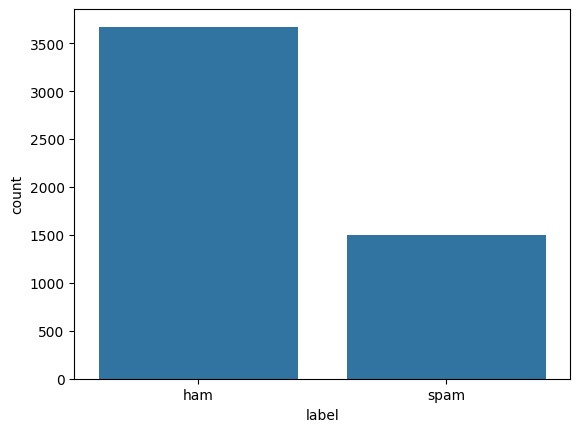

In [17]:
sns.countplot(x="label",data=data)
plt.show()

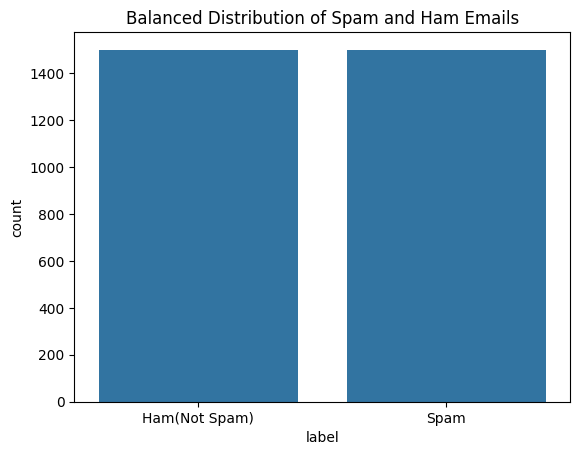

In [21]:
ham_msg=data[data["label"]=="ham"]
spam_msg=data[data["label"]=="spam"]
ham_msg_balanced=ham_msg.sample(n=len(spam_msg),random_state=42)
balanced_data=pd.concat([ham_msg_balanced,spam_msg]).reset_index(drop=True)
sns.countplot(x="label",data=balanced_data)
plt.title("Balanced Distribution of Spam and Ham Emails")
plt.xticks(ticks=[0,1],labels=["Ham(Not Spam)","Spam"])
plt.show()

In [23]:
balanced_data["text"]=balanced_data["text"].str.replace("Subject","")
balanced_data.head()

,Unnamed: 0,label,text,label_num
0,3444,ham,: conoco - big cowboy\r\ndarren :\r\ni ' m not...,0
1,2982,ham,: feb 01 prod : sale to teco gas processing\r\...,0
2,2711,ham,": california energy crisis\r\ncalifornia  , s...",0
3,3116,ham,: re : nom / actual volume for april 23 rd\r\n...,0
4,1314,ham,: eastrans nomination changes effective 8 / 2 ...,0


In [25]:
punctuations_list=string.punctuation
def remove_punctuations(text):
    temp=str.maketrans("","",punctuations_list)
    return text.translate(temp)
balanced_data["text"]=balanced_data["text"].apply(lambda x: remove_punctuations(x))
balanced_data.head()

,Unnamed: 0,label,text,label_num
0,3444,ham,conoco big cowboy\r\ndarren \r\ni m not sur...,0
1,2982,ham,feb 01 prod sale to teco gas processing\r\ns...,0
2,2711,ham,california energy crisis\r\ncalifornia  s p...,0
3,3116,ham,re nom actual volume for april 23 rd\r\nwe ...,0
4,1314,ham,eastrans nomination changes effective 8 2 0...,0


In [31]:
def remove_stopwords(text):
    stop_words=stopwords.words("english")
    imp_words=[]
    for word in str(text).split():
        word=word.lower()
        if word not in stop_words:
            imp_words.append(word)
    output=" ".join(imp_words)
    return output
balanced_data["text"]=balanced_data["text"].apply(lambda text: remove_stopwords(text))
balanced_data.head()

,Unnamed: 0,label,text,label_num
0,3444,ham,conoco big cowboy darren sure help know else a...,0
1,2982,ham,feb 01 prod sale teco gas processing sale deal...,0
2,2711,ham,california energy crisis california  power cr...,0
3,3116,ham,nom actual volume april 23 rd agree eileen pon...,0
4,1314,ham,eastrans nomination changes effective 8 2 00 p...,0


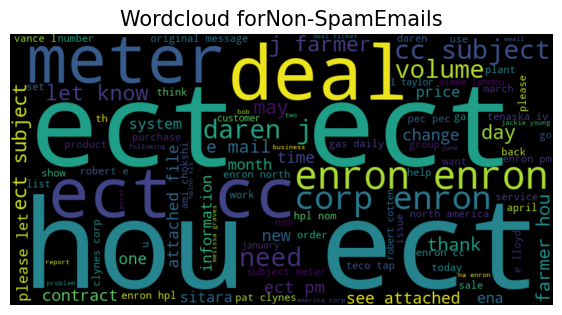

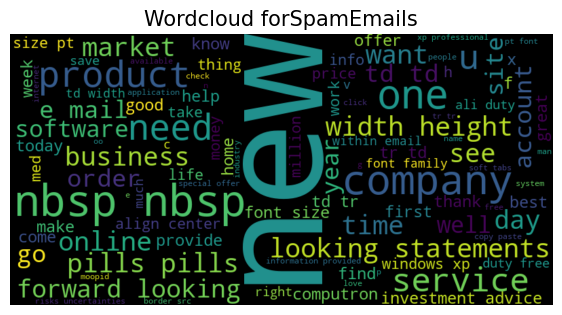

In [37]:
def plot_word_cloud(data,typ):
    email_corpus=" ".join(data["text"])
    wc=WordCloud(background_color="black",max_words=100,width=800,height=400).generate(email_corpus)
    plt.figure(figsize=(7,7))
    plt.imshow(wc,interpolation="bilinear")
    plt.title(f"Wordcloud for{typ}Emails",fontsize=15)
    plt.axis("off")
    plt.show()
plot_word_cloud(balanced_data[balanced_data["label"]=="ham"],typ="Non-Spam")
plot_word_cloud(balanced_data[balanced_data["label"]=="spam"],typ="Spam")

In [41]:
train_x,test_x,train_y,test_y=train_test_split(balanced_data["text"],balanced_data["label"],test_size=0.2,random_state=42)
tokenizer=Tokenizer()
tokenizer.fit_on_texts(train_x)
train_sequences=tokenizer.texts_to_sequences(train_x)
test_sequences=tokenizer.texts_to_sequences(test_x)
max_len=100
train_sequences=pad_sequences(train_sequences,maxlen=max_len,padding="post",truncating="post")
test_sequences=pad_sequences(test_sequences,maxlen=max_len,padding="post",truncating="post")
train_y=(train_y=="spam").astype(int)
test_y=(test_y=="spam").astype(int)

In [45]:
model=tf.keras.models.Sequential([tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index)+1,output_dim=32,input_length=max_len),
                                  tf.keras.layers.LSTM(16),
                                  tf.keras.layers.Dense(32,activation="relu"),
                                  tf.keras.layers.Dense(1,activation="sigmoid")
                                 ])
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer="adam",
    metrics=["accuracy"]
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 32)           1274912   
                                                                 
 lstm (LSTM)                 (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 32)                544       
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,278,625
Trainable params: 1,278,625
Non-trainable params: 0
_________________________________________________________________


In [49]:
es=EarlyStopping(patience=3,monitor="val_accuracy",restore_best_weights=True)
lr=ReduceLROnPlateau(patience=2,monitor="val_loss",factor=0.5,verbose=0)
history=model.fit(train_sequences,train_y,validation_data=(test_sequences,test_y),epochs=20,batch_size=32,callbacks=[lr,es])

Epoch 1/20
75/75 [==============================] - 13s 106ms/step - loss: 0.6877 - accuracy: 0.5696 - val_loss: 0.5967 - val_accuracy: 0.6467 - lr: 0.0010
Epoch 2/20
75/75 [==============================] - 7s 88ms/step - loss: 0.2688 - accuracy: 0.9324 - val_loss: 0.1554 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 3/20
75/75 [==============================] - 6s 86ms/step - loss: 0.1629 - accuracy: 0.9621 - val_loss: 0.1895 - val_accuracy: 0.9517 - lr: 0.0010
Epoch 4/20
75/75 [==============================] - 6s 79ms/step - loss: 0.1369 - accuracy: 0.9696 - val_loss: 0.1506 - val_accuracy: 0.9650 - lr: 0.0010
Epoch 5/20
75/75 [==============================] - 6s 84ms/step - loss: 0.1206 - accuracy: 0.9729 - val_loss: 0.0945 - val_accuracy: 0.9783 - lr: 0.0010
Epoch 6/20
75/75 [==============================] - 6s 82ms/step - loss: 0.0994 - accuracy: 0.9796 - val_loss: 0.1285 - val_accuracy: 0.9717 - lr: 0.0010
Epoch 7/20
75/75 [==============================] - 7s 88ms/step - loss: 0

In [54]:
test_loss,test_accuracy=model.evaluate(test_sequences,test_y)
print("Test Loss:",test_loss)
print("Test Accuracy:",test_accuracy)

19/19 [==============================] - 0s 19ms/step - loss: 0.0812 - accuracy: 0.9817
Test Loss: 0.08120325207710266
Test Accuracy: 0.9816666841506958


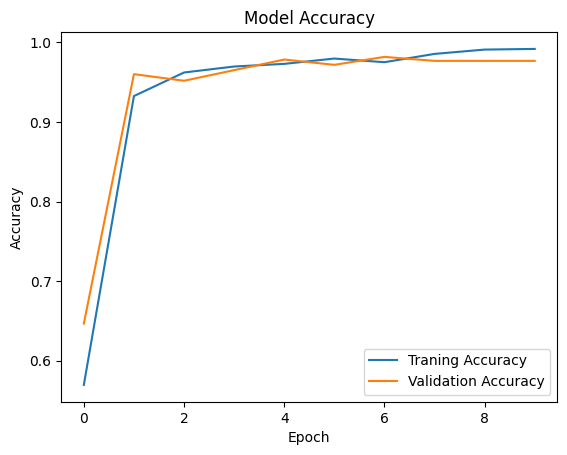

In [56]:
plt.plot(history.history["accuracy"],label="Traning Accuracy")
plt.plot(history.history["val_accuracy"],label="Validation Accuracy")
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()